# CATBOOST CLASSIFIER ---------------------------------------------------------------------------

### Get Train, Valid, Test data

In [1]:
import pandas as pd
from my_libs import lib_tools as pt

# run_type = 'dev'         # uncomment this line to have a quick execution
run_type = 'prd'           # uncomment this lone for normal execution
gen_sample = True          # True : execute SMOTEN resampling before CatBoost - False : load previously "smoted" data from pickle file
find_best_params = False   # True : look for the best hyperparameters with Optuna (can be long)
add_random_var = False     # True : add a random variable to the dataset to check if some variables have less importance than this random variable
all_var = True             # True : consider all columns of the dataset - False : consider 10 most important features according CatBoost

if all_var:
    columns = None
else:
    columns = ['dep', 'catv', 'catr', 'col', 'agg', 'trajet', 'mois', 'catu', 'situ', 'place']

X_train, y_train, X_valid, y_valid, X_test, y_test = pt.get_train_valid_test_data(run_type, columns)
print("Train, Valid and Test data loaded")

columns = list(X_train.columns)

Train, Valid and Test data loaded


### Resample data with SMOTEN()

C:\Users\nicol\AppData\Roaming\Python\Python39\site-packages\imblearn\over_sampling\_smote\base.py:858: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


--- Smote applied in 273.2460901737213 seconds ---
Classes cardinality after resampling :
1    48850
0    48850
Name: grav, dtype: int64
X shape : (64000, 26) -> (97700, 26)
y shape : (64000,) -> (97700,)


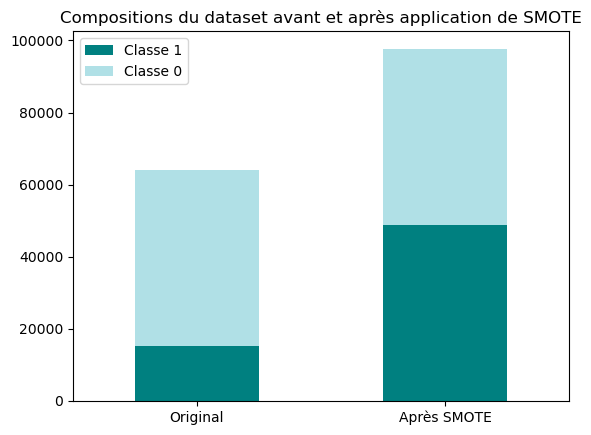

In [2]:
if gen_sample:
    X_train_rs, y_train_rs = pt.get_data_resampled(X=X_train, y=y_train, verbose=1)
    # Save data generated
    X_train_rs.to_pickle(f'./pickles/X_train_smote_{run_type}_cb_{X_train.shape[0]}x{X_train.shape[1]}.pkl')
    y_train_rs.to_pickle(f'./pickles/y_train_smote_{run_type}_cb_{X_train.shape[0]}x{X_train.shape[1]}.pkl')
else:
    # Load data previously generated
    X_train_rs = pd.read_pickle(f'./pickles/X_train_smote_{run_type}_cb_{X_train.shape[0]}x{X_train.shape[1]}.pkl')
    y_train_rs = pd.read_pickle(f'./pickles/y_train_smote_{run_type}_cb_{X_train.shape[0]}x{X_train.shape[1]}.pkl')

pt.plot_data_augmentation(y_train, y_train_rs)

### Add random variable

In [3]:
import numpy as np
if add_random_var:
    X_train_rs['rand'] = np.random.choice(a=[0, 1, 2, 3, 4], size=X_train_rs.shape[0], p=[0.2, 0.2, 0.2, 0.2, 0.2])
    X_valid['rand']    = np.random.choice(a=[0, 1, 2, 3, 4], size=X_valid.shape[0], p=[0.2, 0.2, 0.2, 0.2, 0.2])
    X_test['rand']     = np.random.choice(a=[0, 1, 2, 3, 4], size=X_test.shape[0],  p=[0.2, 0.2, 0.2, 0.2, 0.2])

### Find best hyperparameters for model with Optuna (or load model previously fitted)

In [4]:
import time
import optuna
from sklearn.model_selection import cross_val_score
from catboost import CatBoostClassifier

if find_best_params:

    start_time = time.time()

    def objective(trial):

        dt_iterations    = trial.suggest_int('iterations', 50, 2000, log=True)
        dt_learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)

        classifier_obj = CatBoostClassifier(iterations=dt_iterations, learning_rate=dt_learning_rate, cat_features=list(X_train.columns), verbose=0)
        score = cross_val_score(classifier_obj, X_train_rs, y_train_rs, cv=5, scoring="f1", verbose=1)
        accuracy = score.mean()

        return accuracy

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=5)

    print("--- CatBoost Classifier - Optimization with Optuna performed in %s seconds ---" % (time.time() - start_time))
    print(f"Best params : {study.best_params}")
    
    from optuna.visualization import plot_optimization_history
    fig = plot_optimization_history(study)
    fig.show()

### Load and Train model

In [5]:
if find_best_params:
    # model coming from optuna search
    params = study.best_params
    params['cat_features'] = columns
else:
    # train best model    
    n_iter = 206
    l_r = 0.0811    
    params = {'iterations': n_iter, 'learning_rate': l_r, 'custom_loss': ['AUC'], 'cat_features': columns}
    
model = CatBoostClassifier(**params, verbose=0)   
model.fit(X_train_rs, y_train_rs, eval_set=(X_test, y_test), plot=True);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Confusion Matrix

In [6]:
best_auc = model.best_score_['validation']['AUC']
n_iter = model.evals_result_['validation']['AUC'].index(best_auc)
n_iter

191

In [7]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)    
display(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print("\nClassification report -------------------------------\n")
print(classification_report(y_test, y_pred))

Classe prédite,0,1
Classe réelle,,
0,13928,2373
1,1867,1831



Classification report -------------------------------

              precision    recall  f1-score   support

           0       0.88      0.85      0.87     16301
           1       0.44      0.50      0.46      3698

    accuracy                           0.79     19999
   macro avg       0.66      0.67      0.67     19999
weighted avg       0.80      0.79      0.79     19999



### Plot ROC curves (from estimator & from predictions)

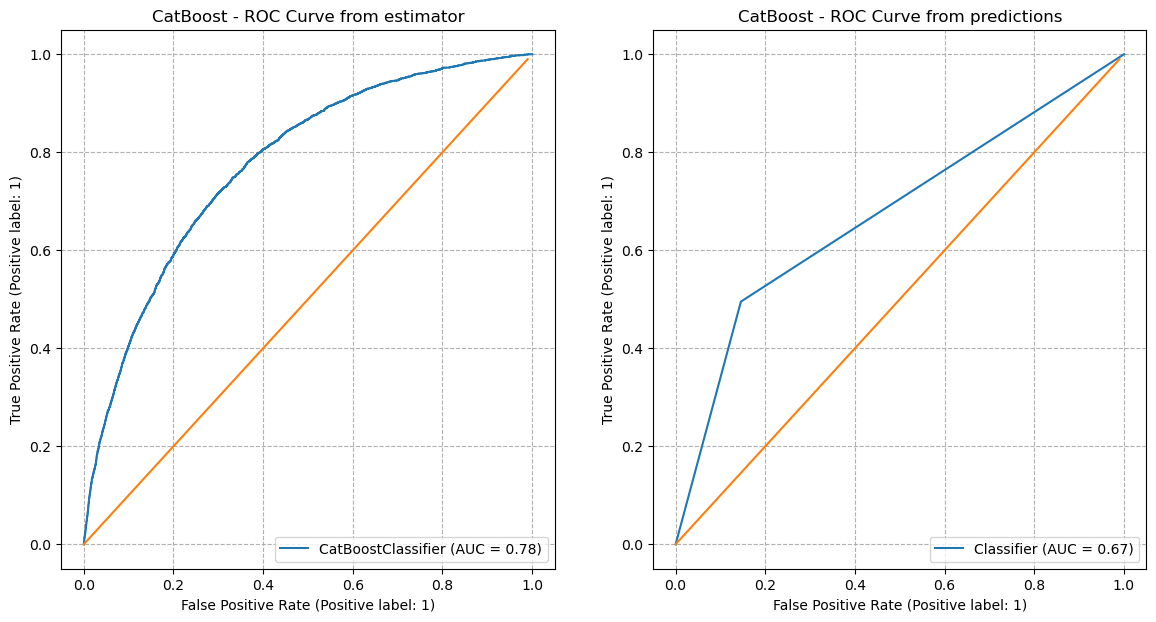

In [8]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(1,2, figsize=(14,7))
RocCurveDisplay.from_estimator(model, X_test, y_test, ax=axs[0])
axs[0].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
axs[0].set_title('CatBoost - ROC Curve from estimator')
axs[0].grid(linestyle='--')
RocCurveDisplay.from_predictions(y_test, model.predict(X_test), ax=axs[1])
axs[1].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
axs[1].set_title('CatBoost - ROC Curve from predictions');
axs[1].grid(linestyle='--')

### Change proba threshold to improve f1-score

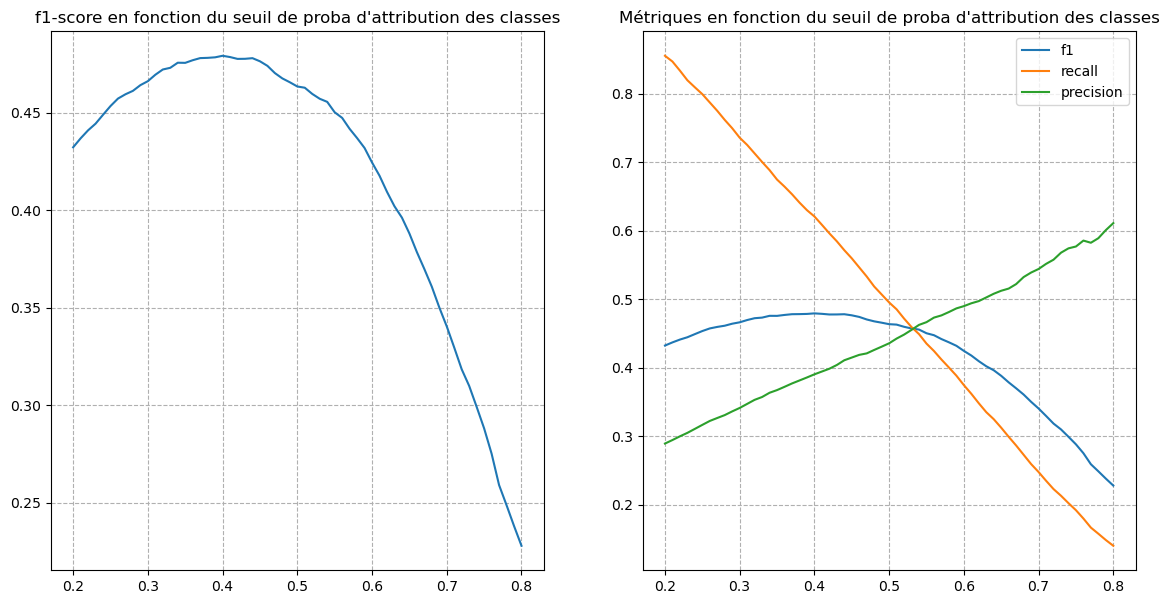

In [9]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from scikitplot.metrics import plot_roc_curve

thresholds = np.arange(0.20, 0.80, 0.01)
scores_f1 = []
scores_prec = []
scores_recall = []
for k in thresholds:
    y_pred = (model.predict_proba(X_test)[:,1] >= k).astype(bool)
    scores_f1.append(f1_score(y_test, y_pred))
    scores_prec.append(precision_score(y_test, y_pred))
    scores_recall.append(recall_score(y_test, y_pred))
    
import matplotlib.pyplot as plt
%matplotlib inline
# fig, axs = plt.subplots(2,1, figsize=(7,10))
# plt.grid()

fig, axs = plt.subplots(1,2, figsize=(14,7))
axs[0].plot(thresholds, scores_f1, label='f1')
axs[0].set_title("f1-score en fonction du seuil de proba d'attribution des classes")
axs[0].grid(linestyle='--')
axs[1].plot(thresholds, scores_f1, label='f1')
axs[1].plot(thresholds, scores_recall, label='recall')
axs[1].plot(thresholds, scores_prec, label='precision')
axs[1].set_title("Métriques en fonction du seuil de proba d'attribution des classes")
axs[1].grid(linestyle='--')
plt.legend();

In [10]:
from sklearn.metrics import classification_report
y_pred = (model.predict_proba(X_test)[:,1] >= 0.42).astype(bool)

display(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))

print("\nClassification report :")
print(classification_report(y_test, y_pred))

Classe prédite,False,True
Classe réelle,,
0,12973,3328
1,1494,2204



Classification report :
              precision    recall  f1-score   support

           0       0.90      0.80      0.84     16301
           1       0.40      0.60      0.48      3698

    accuracy                           0.76     19999
   macro avg       0.65      0.70      0.66     19999
weighted avg       0.80      0.76      0.78     19999



### Explainability with Shapash

In [11]:
from shapash import SmartExplainer
from my_libs import ref_labels
import pickle
import shap
shap.initjs()

if all_var :
    label_dict = ref_labels.dic_target
    preprocessing = ref_labels.dic_preproc
    features_dic = ref_labels.dic_features
else :
    label_dict = None
    preprocessing = None
    features_dic = None

xpl = SmartExplainer(
    model=model,
    label_dict=label_dict,
    preprocessing=preprocessing,
    features_dict=features_dic,  # Optional parameter
)

y_test.index = X_test.index

xpl.compile(
    x=X_test,
    # y_pred=y_pred, # Optional: for your own prediction (by default: model.predict)
    y_target=y_test, # Optional: allows to display True Values vs Predicted Values
)

app = xpl.run_app()

Exception: Columns senc not in dataframe.

In [ ]:
# app.kill()

### Features importance according CatBoost

In [ ]:
df_importances = pd.DataFrame({'col':X_train_rs.columns, 'importance':model.get_feature_importance()})
df_importances = df_importances.sort_values(by=['importance'], ascending=False)
df_importances = df_importances.set_index('col')

ax1 = df_importances.plot.bar()
ax1.set_facecolor('white')
ax1.set_title('Importance des variables selon CatBoost');

In [ ]:
df_importances

### Features importance according Shapash

In [ ]:
xpl.features_imp

In [ ]:
xpl.plot.features_importance()

### Save model to h5

In [ ]:
from joblib import dump
# Save the model to an h5 file using joblib
dump(model, f'h5_models/model_cb_{run_type}_{X_train.shape[0]}.h5')